# Case Study 1: Customer Churn Prediction
Machine Learning Classification Analysis

In [ ]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import io

In [ ]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Running on Apple Metal (MPS) - M-series Mac detected.")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using NVIDIA CUDA device.")
else:
    device = torch.device("cpu")
    print("Using CPU device.")

Using CPU device.


TASK 1

In [ ]:
# Loading the CSV file
file_path = 'customer_churn_data.csv'
try:
    churn_df = pd.read_csv(file_path)  # Try reading the dataset
    print("Dataset loaded successfully.", file_path)
except FileNotFoundError:
    print("Error, the file was not found.")  # If file doesn't exist, show error
    exit()

# Display dataset information
print("\nDataFrame Info:")
print("Dataset Shape:", churn_df.shape)  # Print number of rows and columns
churn_df.info()  # Show column names, data types, and non-null counts

# Check missing values before handling
print("\n--- Missing Values Before Handling ---")
print(churn_df.isnull().sum())

# Convert 'total_charges' column to numeric
# If any value is not a number (like blank or string), it will be turned into NaN
churn_df['total_charges'] = pd.to_numeric(churn_df['total_charges'], errors='coerce')

# Fill missing 'total_charges' with its median value
median_total_charges = churn_df['total_charges'].median()
churn_df['total_charges'].fillna(median_total_charges, inplace=True)

# Check missing values after handling
print("\n--- Missing Values After Handling ---")
print(churn_df.isnull().sum())

# Show summary statistics for numerical columns
print("\n--- Summary Statistics ---")
print(churn_df.describe())


Dataset loaded successfully. customer_churn_data.csv

DataFrame Info:
Dataset Shape: (10000, 24)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   customer_id            10000 non-null  object 
 1   age                    10000 non-null  int64  
 2   gender                 10000 non-null  object 
 3   senior_citizen         10000 non-null  int64  
 4   partner                10000 non-null  object 
 5   dependents             10000 non-null  object 
 6   tenure                 10000 non-null  int64  
 7   phone_service          10000 non-null  object 
 8   multiple_lines         10000 non-null  object 
 9   internet_service       10000 non-null  object 
 10  online_security        10000 non-null  object 
 11  online_backup          10000 non-null  object 
 12  device_protection      10000 non-null  object 
 13  tech_suppo

/tmp/ipython-input-1682936297.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  churn_df['total_charges'].fillna(median_total_charges, inplace=True)


TASK 2

Task 2: Exploratory Data Analysis (EDA)


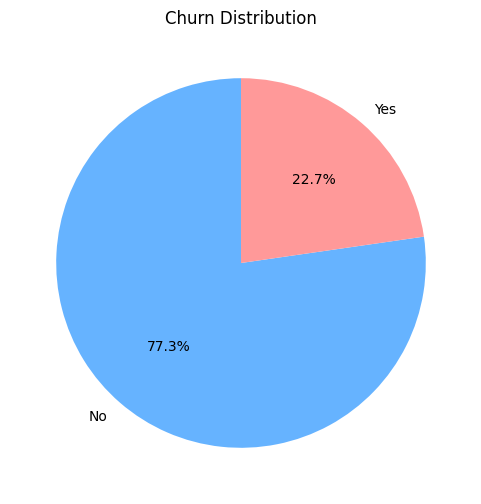


Overall Churn Rate: 22.72%


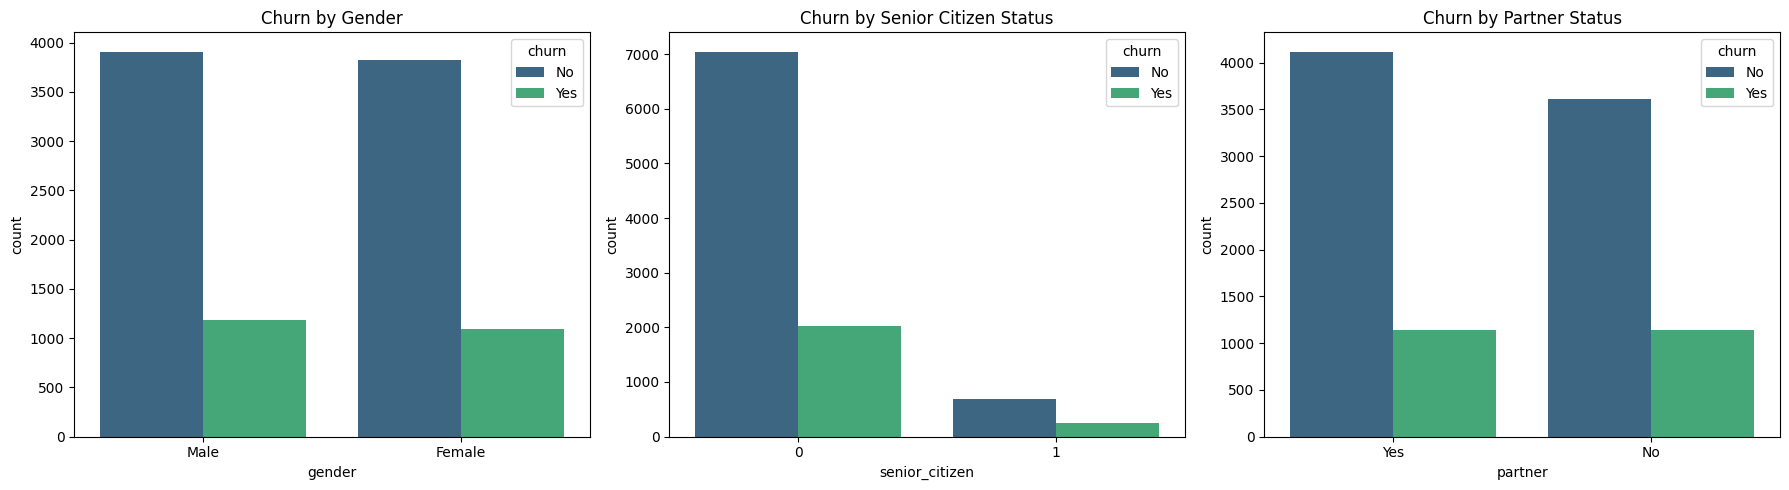

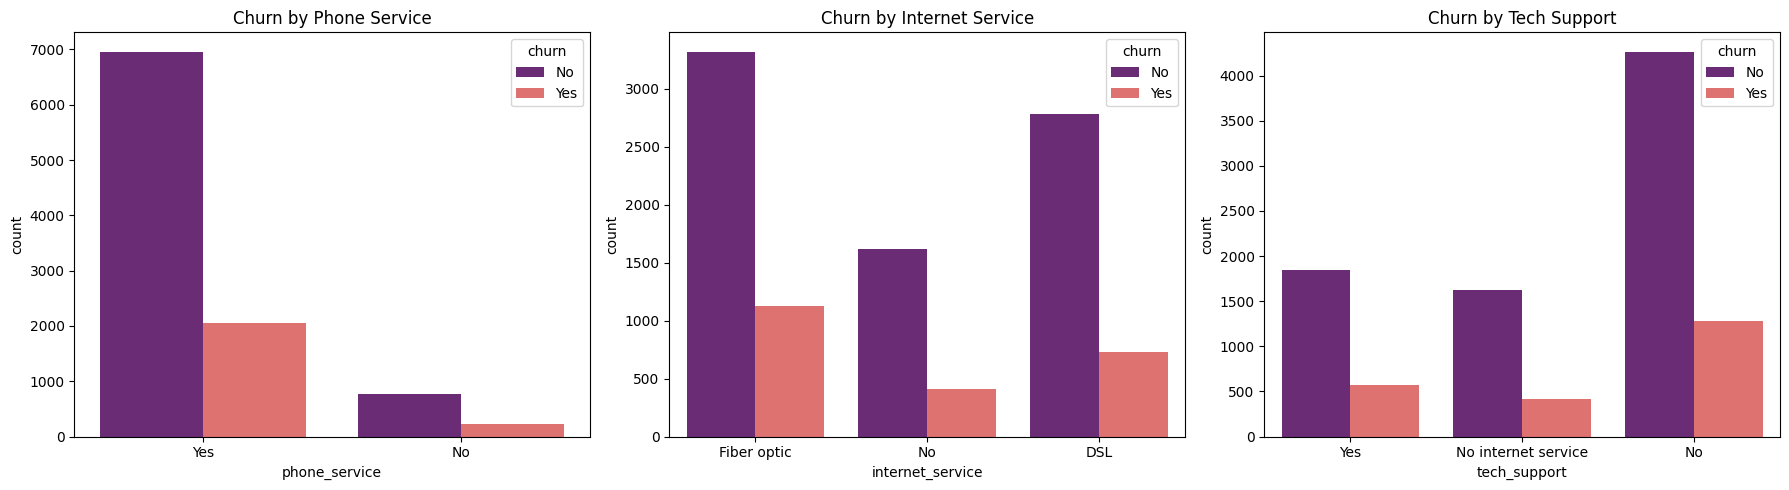

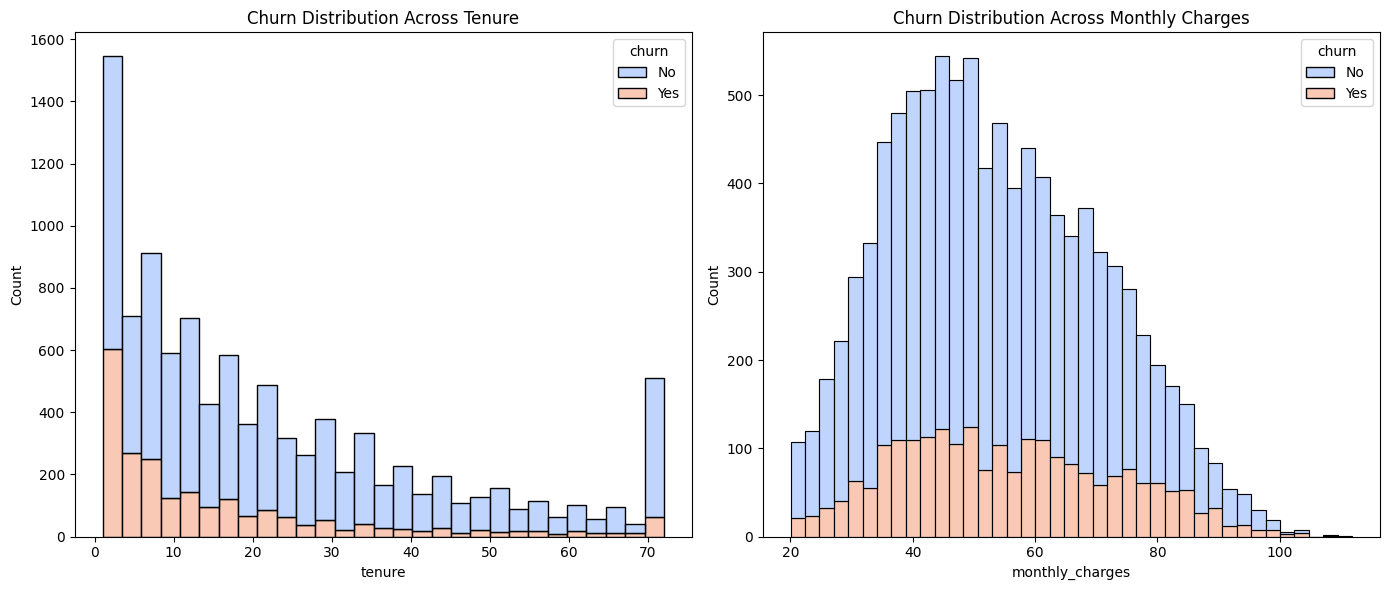

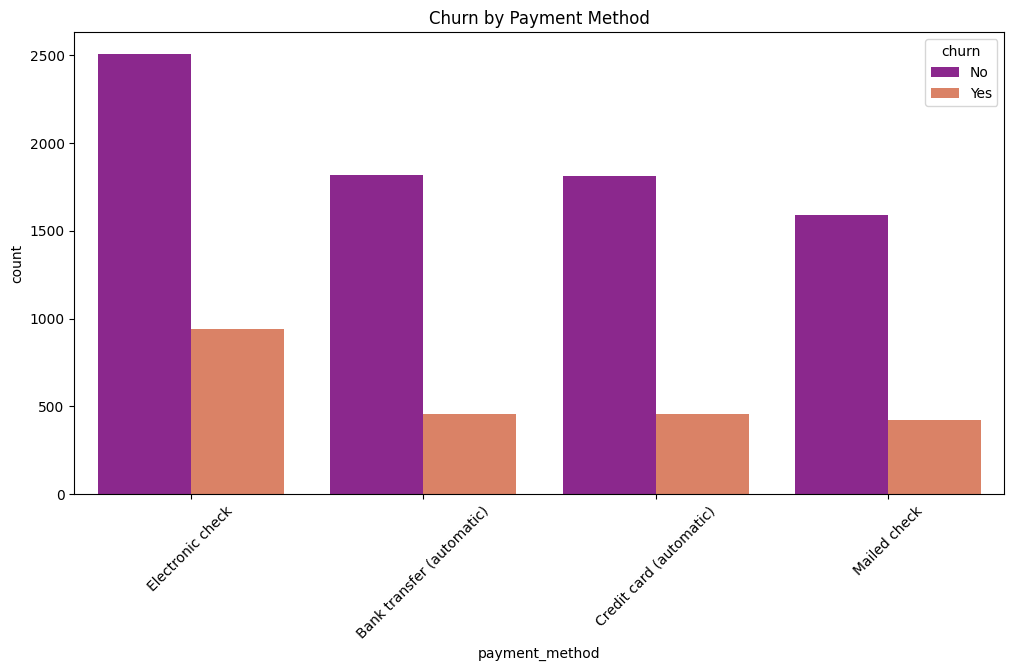

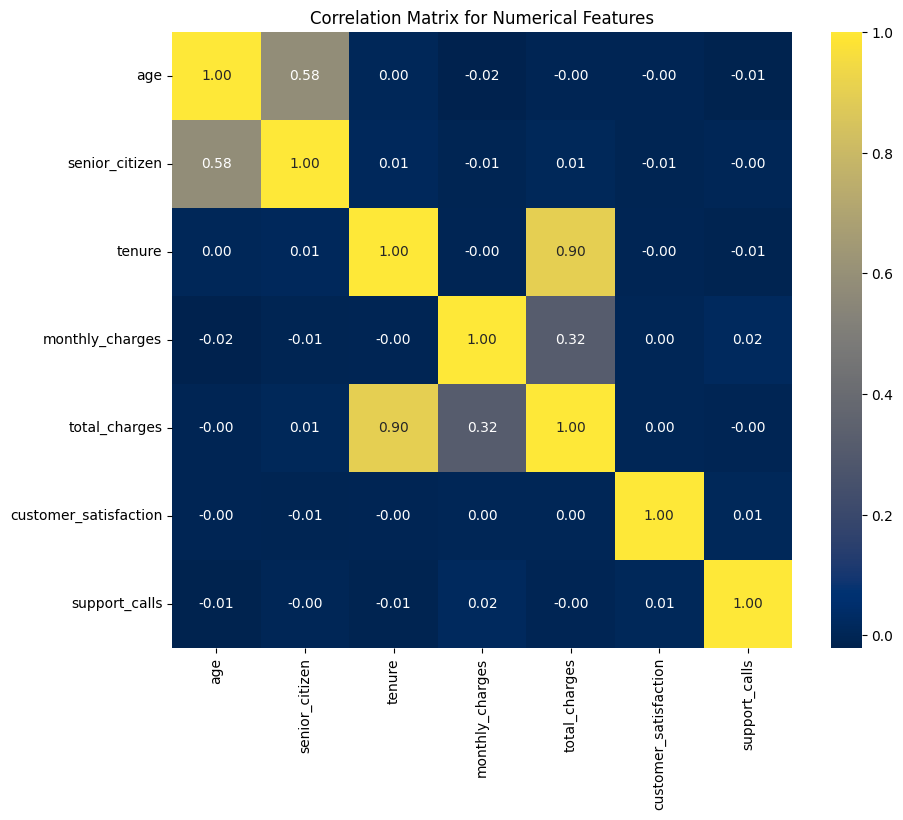

In [ ]:
print("Task 2: Exploratory Data Analysis (EDA)")

# Analyze churn distribution and compute overall churn rate
plt.figure(figsize=(6, 6))
churn_counts = churn_df['churn'].value_counts()
plt.pie(churn_counts, labels=churn_counts.index, autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#ff9999'])
plt.title('Churn Distribution')
plt.show()

overall_churn_rate = (churn_df['churn'] == 'Yes').sum() / len(churn_df)
print(f"\nOverall Churn Rate: {overall_churn_rate:.2%}")


# Examine demographics and service usage patterns affecting churn
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.countplot(ax=axes[0], x='gender', hue='churn', data=churn_df, palette='viridis')
axes[0].set_title('Churn by Gender')
sns.countplot(ax=axes[1], x='senior_citizen', hue='churn', data=churn_df, palette='viridis')
axes[1].set_title('Churn by Senior Citizen Status')
sns.countplot(ax=axes[2], x='partner', hue='churn', data=churn_df, palette='viridis')
axes[2].set_title('Churn by Partner Status')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.countplot(ax=axes[0], x='phone_service', hue='churn', data=churn_df, palette='magma')
axes[0].set_title('Churn by Phone Service')
sns.countplot(ax=axes[1], x='internet_service', hue='churn', data=churn_df, palette='magma')
axes[1].set_title('Churn by Internet Service')
sns.countplot(ax=axes[2], x='tech_support', hue='churn', data=churn_df, palette='magma')
axes[2].set_title('Churn by Tech Support')
plt.tight_layout()
plt.show()


# Analyze financial aspects and payment methods
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.histplot(ax=axes[0], data=churn_df, x='tenure', hue='churn', multiple='stack', palette='coolwarm')
axes[0].set_title('Churn Distribution Across Tenure')
sns.histplot(ax=axes[1], data=churn_df, x='monthly_charges', hue='churn', multiple='stack', palette='coolwarm')
axes[1].set_title('Churn Distribution Across Monthly Charges')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.countplot(x='payment_method', hue='churn', data=churn_df, palette='plasma')
plt.title('Churn by Payment Method')
plt.xticks(rotation=45)
plt.show()


# Correlation analysis for numerical features
numeric_cols = churn_df.select_dtypes(include=np.number).columns
corr_matrix = churn_df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='cividis', fmt='.2f')
plt.title('Correlation Matrix for Numerical Features')
plt.show()


TASK 3

In [9]:
print("Task 3: Data Preprocessing")

# Encode binary categorical variables as 0 and 1
binary_cols = ['gender', 'partner', 'dependents', 'phone_service', 'paperless_billing', 'churn']
for col in binary_cols:
    # Convert 'Yes' and 'Male' to 1, everything else to 0
    churn_df[col] = churn_df[col].apply(lambda x: 1 if x == 'Yes' or x == 'Male' else 0)

# Convert remaining categorical variables into dummy/one-hot encoded variables
categorical_cols = churn_df.select_dtypes(include=['object']).columns
churn_df = pd.get_dummies(churn_df, columns=categorical_cols, drop_first=True)

print("\n--- Dataset Preview After Encoding ---")
print(churn_df.head())
print("\n--- Dataset Shape After Encoding ---")
print(churn_df.shape)


# Scale numerical features between 0 and 1 using Min-Max scaling
numerical_features = ['tenure', 'monthly_charges', 'total_charges']

# Convert numerical features to a PyTorch tensor
data_tensor = torch.tensor(churn_df[numerical_features].values, dtype=torch.float32)

# Compute min and max values for scaling
min_vals = data_tensor.min(dim=0, keepdim=True).values
max_vals = data_tensor.max(dim=0, keepdim=True).values

# Apply Min-Max scaling
scaled_tensor = (data_tensor - min_vals) / (max_vals - min_vals)
churn_df[numerical_features] = scaled_tensor.numpy()

print("\n--- Dataset Preview After Scaling ---")
print(churn_df.head())


# Split dataset into features (X) and target (y)
X = churn_df.drop('churn', axis=1)
y = churn_df['churn']

# Convert to PyTorch tensors
X_tensor = torch.tensor(X.astype(np.float32).values)
y_tensor = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)

# Shuffle data
torch.manual_seed(42)
indices = torch.randperm(len(X_tensor))

# Define train, validation, and test set sizes
train_size = int(0.7 * len(X_tensor))
val_size = int(0.15 * len(X_tensor))
test_size = len(X_tensor) - train_size - val_size

# Split indices
train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

# Create train, validation, and test sets
X_train, y_train = X_tensor[train_indices], y_tensor[train_indices]
X_val, y_val = X_tensor[val_indices], y_tensor[val_indices]
X_test, y_test = X_tensor[test_indices], y_tensor[test_indices]

print(f"\nTrain set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")


Task 3: Data Preprocessing

--- Dataset Preview After Encoding ---
   age  gender  senior_citizen  partner  dependents  tenure  phone_service  \
0   52       1               0        1           1       7              1   
1   42       1               0        1           0      32              1   
2   54       1               0        0           1      12              1   
3   67       1               1        0           0       3              1   
4   41       0               0        1           0       7              1   

   paperless_billing  monthly_charges  total_charges  ...  tech_support_Yes  \
0                  1            39.18         294.66  ...              True   
1                  1            40.36        1286.75  ...             False   
2                  0            84.77         947.09  ...             False   
3                  0            54.14         172.76  ...             False   
4                  1            71.77         466.98  ...            

TASK 4


In [10]:
print("Task 4: Model Development")

# -----------------------------
# Implement Logistic Regression
# -----------------------------

# Define input and output dimensions
input_features = X_train.shape[1]
output_features = 1

# Hyperparameters
learning_rate = 0.01
epochs = 1000

# Define the model
model_lr = torch.nn.Linear(input_features, output_features)

# Define the loss function (BCE with logits for numerical stability)
criterion_lr = torch.nn.BCEWithLogitsLoss()

# Define the optimizer (Stochastic Gradient Descent)
optimizer_lr = torch.optim.SGD(model_lr.parameters(), lr=learning_rate)

for epoch in range(epochs):
    # Forward pass: compute predicted outputs
    outputs = model_lr(X_train)

    # Compute loss
    loss = criterion_lr(outputs, y_train)

    # Backward pass: compute gradients
    optimizer_lr.zero_grad()
    loss.backward()

    # Update model parameters
    optimizer_lr.step()

    # Print loss every 100 epochs
    if (epoch + 1) % 100 == 0:
        print(f'Logistic Regression - Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

print("\n✅ Logistic Regression training complete.")


Task 4: Model Development
Logistic Regression - Epoch [100/1000], Loss: 0.7733
Logistic Regression - Epoch [200/1000], Loss: 0.7644
Logistic Regression - Epoch [300/1000], Loss: 1.9043
Logistic Regression - Epoch [400/1000], Loss: 0.6133
Logistic Regression - Epoch [500/1000], Loss: 0.8167
Logistic Regression - Epoch [600/1000], Loss: 1.9487
Logistic Regression - Epoch [700/1000], Loss: 0.6640
Logistic Regression - Epoch [800/1000], Loss: 0.8272
Logistic Regression - Epoch [900/1000], Loss: 1.8837
Logistic Regression - Epoch [1000/1000], Loss: 0.7093

✅ Logistic Regression training complete.


TASK 5

Task 5: Model Evaluation

Logistic Regression - Validation Metrics
Accuracy : 0.4253
Precision: 0.2528
Recall   : 0.8323
F1-Score : 0.3878


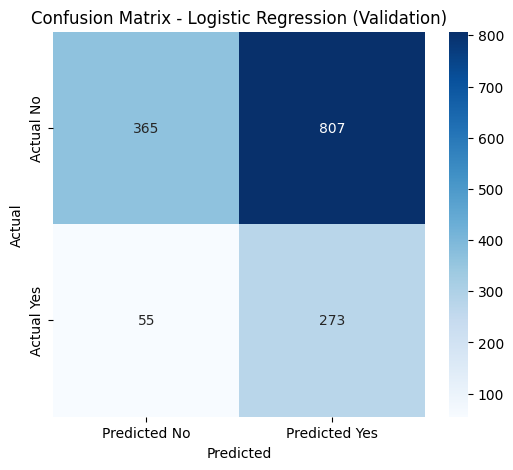


Testing Best Model (Logistic Regression) on Test Set

Logistic Regression - Test Metrics
Accuracy : 0.4160
Precision: 0.2605
Recall   : 0.8614
F1-Score : 0.4000


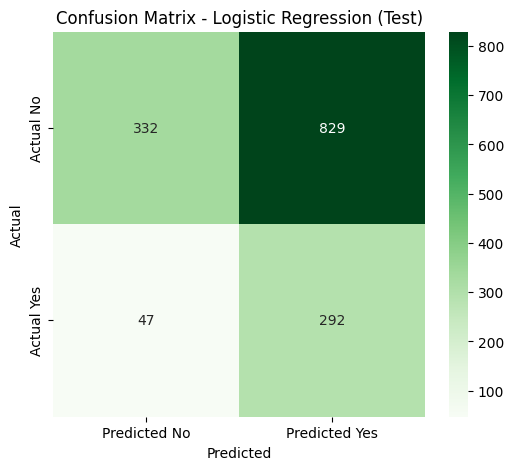

In [11]:
print("Task 5: Model Evaluation")

# -----------------------------
# Evaluate Logistic Regression on Validation Set
# -----------------------------
with torch.no_grad():
    # Get raw model outputs
    y_val_pred_logits = model_lr(X_val)

    # Apply sigmoid to get probabilities
    y_val_pred = torch.sigmoid(y_val_pred_logits)

    # Convert probabilities to binary class labels (0 or 1)
    y_val_pred_class = (y_val_pred > 0.5).float()

    # Compute confusion matrix components
    tp = ((y_val_pred_class == 1) & (y_val == 1)).sum().item()
    tn = ((y_val_pred_class == 0) & (y_val == 0)).sum().item()
    fp = ((y_val_pred_class == 1) & (y_val == 0)).sum().item()
    fn = ((y_val_pred_class == 0) & (y_val == 1)).sum().item()

    # Calculate evaluation metrics
    accuracy = (tp + tn) / len(y_val)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Print validation metrics
    print("\nLogistic Regression - Validation Metrics")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1-Score : {f1_score:.4f}")

    # Plot confusion matrix for validation
    conf_matrix = np.array([[tn, fp], [fn, tp]])
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted No', 'Predicted Yes'],
                yticklabels=['Actual No', 'Actual Yes'])
    plt.title('Confusion Matrix - Logistic Regression (Validation)')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()


# -----------------------------
# Test the Best Model on Test Set
# -----------------------------
print("\nTesting Best Model (Logistic Regression) on Test Set")
with torch.no_grad():
    y_test_pred_logits = model_lr(X_test)
    y_test_pred = torch.sigmoid(y_test_pred_logits)
    y_test_pred_class = (y_test_pred > 0.5).float()

    # Compute confusion matrix components for test set
    tp_test = ((y_test_pred_class == 1) & (y_test == 1)).sum().item()
    tn_test = ((y_test_pred_class == 0) & (y_test == 0)).sum().item()
    fp_test = ((y_test_pred_class == 1) & (y_test == 0)).sum().item()
    fn_test = ((y_test_pred_class == 0) & (y_test == 1)).sum().item()

    # Calculate metrics for test set
    accuracy_test = (tp_test + tn_test) / len(y_test)
    precision_test = tp_test / (tp_test + fp_test) if (tp_test + fp_test) > 0 else 0
    recall_test = tp_test / (tp_test + fn_test) if (tp_test + fn_test) > 0 else 0
    f1_score_test = 2 * (precision_test * recall_test) / (precision_test + recall_test) if (precision_test + recall_test) > 0 else 0

    # Print test set metrics
    print("\nLogistic Regression - Test Metrics")
    print(f"Accuracy : {accuracy_test:.4f}")
    print(f"Precision: {precision_test:.4f}")
    print(f"Recall   : {recall_test:.4f}")
    print(f"F1-Score : {f1_score_test:.4f}")

    # Plot confusion matrix for test set
    conf_matrix_test = np.array([[tn_test, fp_test], [fn_test, tp_test]])
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Greens',
                xticklabels=['Predicted No', 'Predicted Yes'],
                yticklabels=['Actual No', 'Actual Yes'])
    plt.title('Confusion Matrix - Logistic Regression (Test)')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
